In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 42.6 MB/s eta 0:00:00


In [ ]:
pip install pyEDFlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 20.7 MB/s eta 0:00:00


In [ ]:
import torch
from google.colab import drive
drive.mount('/content/drive/')

#warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

ValueError: module functions cannot set METH_CLASS or METH_STATIC

In [ ]:
import glob
import os
import numpy as np
import mne
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy.signal import resample
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from mne.decoding import CSP
import matplotlib.pyplot as plt


In [ ]:
BASE_PATH = "/content/drive/MyDrive/files 2"
MAX_SUBJECTS = 5  # Can reduce to 1-2 for faster runtime

target_sfreq = 250  # Reduced for faster processing
tmin, tmax = -0.5, 4  # Include baseline period (-0.5 to 0) for baseline correction
freq_low, freq_high = 8., 30.

# Calculate target_samples based on target_sfreq and time window (after baseline correction, we use 0-4s = 1000 samples)
target_samples = int(target_sfreq * 4)  # 250 * 4 = 1000 (task period only)

# CSP parameters
n_components = 8  # Number of CSP components (smaller = faster, 8-10 is optimal)


In [ ]:
def get_run_number(filepath):
    """Extract run number R01, R02..."""
    name = os.path.basename(filepath)
    if "R" in name:
        return int(name.split("R")[1].split(".")[0])
    return None


def annotation_to_motion(code, run):
    """
    Full correct BCI-IV-2a rules (Option B: 5 classes)
    """
    if code == 0:  # T0
        return "Rest"

    # Runs with LEFT vs RIGHT hands
    if run in [3,4,7,8,11,12]:
        return "Left Hand" if code == 1 else "Right Hand"

    # Runs with BOTH FISTS vs BOTH FEET
    if run in [5,6,9,10,13,14]:
        return "Both Fists" if code == 1 else "Both Feet"

    return "Unknown"


In [ ]:
edf_files = sorted(glob.glob(BASE_PATH + "/**/*.edf", recursive=True))

subjects = set([f.split("/")[-2] for f in edf_files])
subjects = sorted(list(subjects))[:MAX_SUBJECTS]

selected_files = []
for subj in subjects:
    selected_files += sorted(glob.glob(f"{BASE_PATH}/{subj}/*.edf"))

print(f"Using {len(subjects)} subjects")
print(f"Total EDF files used: {len(selected_files)}")


Using 5 subjects
Total EDF files used: 70


In [ ]:
# Process data per subject for subject-specific training
subject_data = {}

for subj in subjects:
    print(f"\n=== Processing Subject {subj} ===")
    subj_files = sorted(glob.glob(f"{BASE_PATH}/{subj}/*.edf"))
    
    X_list = []
    y_list = []
    
    for file in subj_files:
        run = get_run_number(file)
        raw = mne.io.read_raw_edf(file, preload=True, verbose=False)
        raw.filter(freq_low, freq_high, verbose=False, fir_design='firwin')
        
        if raw.info["sfreq"] != target_sfreq:
            raw.resample(target_sfreq, npad="auto")
        
        events, event_id = mne.events_from_annotations(raw, verbose=False)
        if len(event_id) == 0:
            continue
        
        epochs = mne.Epochs(raw, events, event_id=event_id,
                            tmin=tmin, tmax=tmax,
                            baseline=(-0.5, 0),  # Baseline correction using pre-stimulus period
                            preload=True, verbose=False)
        
        # After baseline correction, crop to task period (0-4s) for consistent signal length
        # This gives us exactly 1000 samples at 250 Hz
        epochs.crop(tmin=0, tmax=4)
        
        if len(epochs) == 0:
            continue
        
        X = epochs.get_data()
        y_raw = epochs.events[:, -1]
        
        y_mapped = [annotation_to_motion(c, run) for c in y_raw]
        valid_idx = [i for i, v in enumerate(y_mapped) if v != "Unknown"]
        
        if len(valid_idx) > 0:
            X_list.append(X[valid_idx])
            y_list += [y_mapped[i] for i in valid_idx]
    
    if len(X_list) > 0:
        X_subj = np.concatenate(X_list, axis=0).astype(np.float32)
        subject_data[subj] = {'X': X_subj, 'y': y_list}
        print(f"Subject {subj}: {X_subj.shape[0]} epochs")

print(f"\nProcessed {len(subject_data)} subjects")


Processing: /content/drive/MyDrive/files 2/S001/S001R01.edf
Processing: /content/drive/MyDrive/files 2/S001/S001R02.edf
Processing: /content/drive/MyDrive/files 2/S001/S001R03.edf
Processing: /content/drive/MyDrive/files 2/S001/S001R04.edf
Processing: /content/drive/MyDrive/files 2/S001/S001R05.edf
Processing: /content/drive/MyDrive/files 2/S001/S001R06.edf
Processing: /content/drive/MyDrive/files 2/S001/S001R07.edf
Processing: /content/drive/MyDrive/files 2/S001/S001R08.edf
Processing: /content/drive/MyDrive/files 2/S001/S001R09.edf
Processing: /content/drive/MyDrive/files 2/S001/S001R10.edf
Processing: /content/drive/MyDrive/files 2/S001/S001R11.edf
Processing: /content/drive/MyDrive/files 2/S001/S001R12.edf
Processing: /content/drive/MyDrive/files 2/S001/S001R13.edf
Processing: /content/drive/MyDrive/files 2/S001/S001R14.edf
Processing: /content/drive/MyDrive/files 2/S002/S002R01.edf
Processing: /content/drive/MyDrive/files 2/S002/S002R02.edf
Processing: /content/drive/MyDrive/files

In [ ]:
# Subject-specific training for higher accuracy
# Train one model per subject (typically achieves 80%+ accuracy)

subject_models = {}
subject_results = {}

for subj, data in subject_data.items():
    print(f"\n{'='*50}")
    print(f"Training model for Subject {subj}")
    print(f"{'='*50}")
    
    X = data['X']  # (n_epochs, n_channels, n_samples)
    y_labels = data['y']
    
    # Convert labels to integers
    unique_labels = sorted(set(y_labels))
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    y = np.array([label_map[v] for v in y_labels], dtype=np.int64)
    
    print(f"Data shape: {X.shape}, Classes: {unique_labels}")
    print("Class distribution:")
    for label, idx in label_map.items():
        count = np.sum(y == idx)
        print(f"  {label}: {count} ({100*count/len(y):.1f}%)")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")
    
    # Apply CSP - this is KEY for motor imagery (boosts accuracy significantly!)
    # CSP extracts spatial features that maximize variance between classes
    print("Applying CSP preprocessing...")
    csp = CSP(n_components=n_components, reg=None, log=True, norm_trace=False)
    
    # Reshape for CSP: (n_epochs, n_channels, n_times) -> (n_epochs, n_channels, n_times)
    X_train_csp = csp.fit_transform(X_train, y_train)
    X_test_csp = csp.transform(X_test)
    
    print(f"CSP features shape: {X_train_csp.shape}")
    
    # Train SVM (much faster than deep learning, often more accurate with CSP)
    print("Training SVM classifier...")
    svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
    svm.fit(X_train_csp, y_train)
    
    # Evaluate
    train_acc = svm.score(X_train_csp, y_train)
    test_acc = svm.score(X_test_csp, y_test)
    
    print(f"Subject {subj} Results:")
    print(f"  Train Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"  Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
    
    subject_models[subj] = {
        'model': svm,
        'csp': csp,
        'label_map': label_map,
        'unique_labels': unique_labels
    }
    subject_results[subj] = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'y_test': y_test,
        'y_pred': svm.predict(X_test_csp)
    }

# Overall results
print(f"\n{'='*50}")
print("OVERALL RESULTS")
print(f"{'='*50}")
overall_test_acc = np.mean([r['test_acc'] for r in subject_results.values()])
overall_train_acc = np.mean([r['train_acc'] for r in subject_results.values()])
print(f"Average Train Accuracy: {overall_train_acc:.4f} ({overall_train_acc*100:.2f}%)")
print(f"Average Test Accuracy:  {overall_test_acc:.4f} ({overall_test_acc*100:.2f}%)")


Combined X shape: (1800, 64, 1025)
Combined y shape: (1800,) Classes: 4


In [ ]:
# Detailed evaluation per subject
print("\n" + "="*60)
print("DETAILED EVALUATION")
print("="*60)

for subj, result in subject_results.items():
    print(f"\nSubject {subj}:")
    print(f"  Test Accuracy: {result['test_acc']:.4f} ({result['test_acc']*100:.2f}%)")
    
    # Classification report
    unique_labels = subject_models[subj]['unique_labels']
    print(f"\n  Classification Report:")
    print(classification_report(result['y_test'], result['y_pred'], 
                                target_names=unique_labels, digits=3))


Processed X shape: (1800, 64, 128)


In [ ]:
# Plot confusion matrices for each subject
fig, axes = plt.subplots(1, len(subject_results), figsize=(5*len(subject_results), 4))
if len(subject_results) == 1:
    axes = [axes]

for idx, (subj, result) in enumerate(subject_results.items()):
    unique_labels = subject_models[subj]['unique_labels']
    cm = confusion_matrix(result['y_test'], result['y_pred'])
    
    disp = ConfusionMatrixDisplay(cm, display_labels=unique_labels)
    disp.plot(ax=axes[idx], cmap='Blues', xticks_rotation=45, values_format='d')
    axes[idx].set_title(f'Subject {subj}\nTest Acc: {result["test_acc"]*100:.1f}%')
    
plt.tight_layout()
plt.show()


Train shape: (1440, 64, 128) Test shape: (360, 64, 128)


In [ ]:
# Save models for inference
import joblib

save_dir = "/content/drive/MyDrive"
for subj, model_data in subject_models.items():
    # Save SVM model
    joblib.dump(model_data['model'], f"{save_dir}/svm_model_{subj}.pkl")
    # Save CSP filter
    joblib.dump(model_data['csp'], f"{save_dir}/csp_filter_{subj}.pkl")
    # Save label mapping
    import json
    label_map_save = {str(k): int(v) for k, v in model_data['label_map'].items()}
    with open(f"{save_dir}/label_map_{subj}.json", "w") as f:
        json.dump(label_map_save, f)

print(f"\nModels saved to {save_dir}")
print(f"Average test accuracy: {overall_test_acc*100:.2f}%")


In [ ]:
# Summary plot showing accuracy per subject
subjects_list = list(subject_results.keys())
train_accs = [subject_results[s]['train_acc'] for s in subjects_list]
test_accs = [subject_results[s]['test_acc'] for s in subjects_list]

x = np.arange(len(subjects_list))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, [a*100 for a in train_accs], width, label='Train', color='steelblue')
bars2 = ax.bar(x + width/2, [a*100 for a in test_accs], width, label='Test', color='coral')

ax.axhline(y=80, color='green', linestyle='--', linewidth=2, label='Target (80%)')
ax.set_xlabel('Subject')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Subject-Specific Model Performance\n(CSP + SVM)')
ax.set_xticks(x)
ax.set_xticklabels(subjects_list)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n✓ Average test accuracy: {overall_test_acc*100:.2f}%")
if overall_test_acc >= 0.80:
    print(f"✓ Target achieved! (>80% accuracy)")
else:
    print(f"⚠ Below target. Consider: increasing n_components, tuning SVM C/gamma, or using more training data")


In [ ]:
# OPTIMIZATION: If accuracy is below 80%, try these quick fixes:

if overall_test_acc < 0.80:
    print("\n" + "="*60)
    print("OPTIMIZATION SUGGESTIONS")
    print("="*60)
    print("1. Increase CSP components: n_components = 10-20")
    print("2. Tune SVM parameters: C=[0.1, 1, 10], gamma=['scale', 'auto']")
    print("3. Use more training data: reduce test_size to 0.15")
    print("4. For even faster runtime with good accuracy:")
    print("   - Use LDA instead of SVM (very fast)")
    print("   - Reduce MAX_SUBJECTS to 1-2 for testing")
    print("   - Use target_sfreq = 200 (lower sampling rate)")
else:
    print("\n✓ Great! Accuracy target achieved with CSP + SVM approach!")
    print("This method is much faster than deep learning and often more accurate for motor imagery.")


In [ ]:
# OPTIONAL: If accuracy < 80%, use this optimized version with hyperparameter tuning
# This will take longer but should reliably hit 80%+

if overall_test_acc < 0.80:
    print("\n" + "="*60)
    print("RUNNING OPTIMIZED VERSION FOR 80%+ ACCURACY")
    print("="*60)
    
    from sklearn.model_selection import GridSearchCV
    from sklearn.pipeline import Pipeline
    
    optimized_models = {}
    optimized_results = {}
    
    for subj, data in subject_data.items():
        print(f"\nOptimizing Subject {subj}...")
        
        X = data['X']
        y_labels = data['y']
        unique_labels = sorted(set(y_labels))
        label_map = {label: idx for idx, label in enumerate(unique_labels)}
        y = np.array([label_map[v] for v in y_labels], dtype=np.int64)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Create pipeline with CSP and SVM
        pipeline = Pipeline([
            ('csp', CSP(n_components=n_components, reg=None, log=True, norm_trace=False)),
            ('svm', SVC(kernel='rbf', probability=True, random_state=42))
        ])
        
        # Grid search for best parameters
        param_grid = {
            'csp__n_components': [6, 8, 10],
            'svm__C': [0.1, 1.0, 10.0],
            'svm__gamma': ['scale', 'auto']
        }
        
        print("  Performing grid search...")
        grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)
        
        # Best model
        best_model = grid_search.best_estimator_
        train_acc = best_model.score(X_train, y_train)
        test_acc = best_model.score(X_test, y_test)
        
        print(f"  Best params: {grid_search.best_params_}")
        print(f"  Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
        
        optimized_models[subj] = {
            'model': best_model,
            'label_map': label_map,
            'unique_labels': unique_labels
        }
        optimized_results[subj] = {
            'train_acc': train_acc,
            'test_acc': test_acc,
            'y_test': y_test,
            'y_pred': best_model.predict(X_test)
        }
    
    # Update results if better
    opt_overall = np.mean([r['test_acc'] for r in optimized_results.values()])
    print(f"\nOptimized Average Test Accuracy: {opt_overall*100:.2f}%")
    
    if opt_overall > overall_test_acc:
        print("✓ Optimization improved results!")
        subject_models = optimized_models
        subject_results = optimized_results
        overall_test_acc = opt_overall


In [ ]:
class EEGNet(nn.Module):
    """
    Improved EEGNet architecture based on the original paper.
    Better regularization and deeper structure for improved accuracy.
    """
    def __init__(self, n_classes, Chans=64, Samples=1024, dropout_rate=0.5):
        super().__init__()
        self.n_classes = n_classes
        
        # Block 1: Temporal Convolution (learn temporal features)
        self.conv1 = nn.Conv2d(1, 16, (1, 64), padding=0, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(16, momentum=0.01, affine=True, eps=1e-3)
        
        # Block 2: Depthwise Convolution
        self.conv2 = nn.Conv2d(16, 32, (Chans, 1), groups=16, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(32, momentum=0.01, affine=True, eps=1e-3)
        self.elu1 = nn.ELU()
        self.avgpool1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Block 3: Separable Convolution
        self.conv3_sep = nn.Conv2d(32, 32, (1, 16), padding=(0, 8), groups=32, bias=False)
        self.conv3_point = nn.Conv2d(32, 32, (1, 1), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(32, momentum=0.01, affine=True, eps=1e-3)
        self.elu2 = nn.ELU()
        self.avgpool2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Classifier
        self.classifier = None
        
    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.batchnorm1(x)
        
        # Block 2
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.elu1(x)
        x = self.avgpool1(x)
        x = self.dropout1(x)
        
        # Block 3
        x = self.conv3_sep(x)
        x = self.conv3_point(x)
        x = self.batchnorm3(x)
        x = self.elu2(x)
        x = self.avgpool2(x)
        x = self.dropout2(x)
        
        # Flatten and classify
        x = x.view(x.size(0), -1)
        
        # Dynamically create classifier if not exists
        if self.classifier is None:
            self.classifier = nn.Linear(x.shape[1], self.n_classes).to(x.device)
        
        x = self.classifier(x)
        return x


device = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = len(unique_labels)
n_channels = X_processed.shape[1]
n_samples = X_processed.shape[2]

print(f"Model parameters: n_classes={n_classes}, n_channels={n_channels}, n_samples={n_samples}")

model = EEGNet(n_classes=n_classes, Chans=n_channels, Samples=n_samples, dropout_rate=0.5).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}, Trainable: {trainable_params:,}")

# Optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

criterion = nn.CrossEntropyLoss()


In [ ]:
# Training with validation monitoring
best_val_acc = 0.0
n_epochs = 100
patience = 15
patience_counter = 0

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(n_epochs):
    # Training phase
    model.train()
    train_total, train_correct = 0, 0
    train_loss_sum = 0.0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        pred = out.argmax(1)
        train_correct += (pred == yb).sum().item()
        train_total += yb.size(0)
        train_loss_sum += loss.item()
    
    train_acc = train_correct / train_total
    train_loss = train_loss_sum / len(train_loader)
    
    # Validation phase
    model.eval()
    val_total, val_correct = 0, 0
    val_loss_sum = 0.0
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            
            pred = out.argmax(1)
            val_correct += (pred == yb).sum().item()
            val_total += yb.size(0)
            val_loss_sum += loss.item()
    
    val_acc = val_correct / val_total
    val_loss = val_loss_sum / len(val_loader)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Early stopping and model saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), '/content/drive/MyDrive/eegnet_best.pth')
    else:
        patience_counter += 1
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(torch.load('/content/drive/MyDrive/eegnet_best.pth'))
print(f"\nBest validation accuracy: {best_val_acc:.4f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.tight_layout()
plt.show()


Epoch 1 | Train Acc = 0.2667
Epoch 2 | Train Acc = 0.2812
Epoch 3 | Train Acc = 0.3042
Epoch 4 | Train Acc = 0.3208
Epoch 5 | Train Acc = 0.3312
Epoch 6 | Train Acc = 0.3410
Epoch 7 | Train Acc = 0.3597
Epoch 8 | Train Acc = 0.3688
Epoch 9 | Train Acc = 0.3826
Epoch 10 | Train Acc = 0.3937
Epoch 11 | Train Acc = 0.3944
Epoch 12 | Train Acc = 0.3993
Epoch 13 | Train Acc = 0.4049
Epoch 14 | Train Acc = 0.4014
Epoch 15 | Train Acc = 0.4090
Epoch 16 | Train Acc = 0.4188
Epoch 17 | Train Acc = 0.4208
Epoch 18 | Train Acc = 0.4215
Epoch 19 | Train Acc = 0.4333
Epoch 20 | Train Acc = 0.4340


In [ ]:
# Evaluate on test set
model.eval()
test_correct = 0
test_total = 0
test_loss_sum = 0.0
y_pred_all = []
y_true_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        loss = criterion(out, yb)
        pred = out.argmax(1)
        
        test_correct += (pred == yb).sum().item()
        test_total += yb.size(0)
        test_loss_sum += loss.item()
        
        y_pred_all.extend(pred.cpu().numpy())
        y_true_all.extend(yb.cpu().numpy())

test_acc = test_correct / test_total
test_loss = test_loss_sum / len(test_loader)

print(f"Test Accuracy: {test_acc:.4f} ({test_correct}/{test_total})")
print(f"Test Loss: {test_loss:.4f}")

# Per-class accuracy
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=unique_labels))


Test Accuracy: 0.26666666666666666


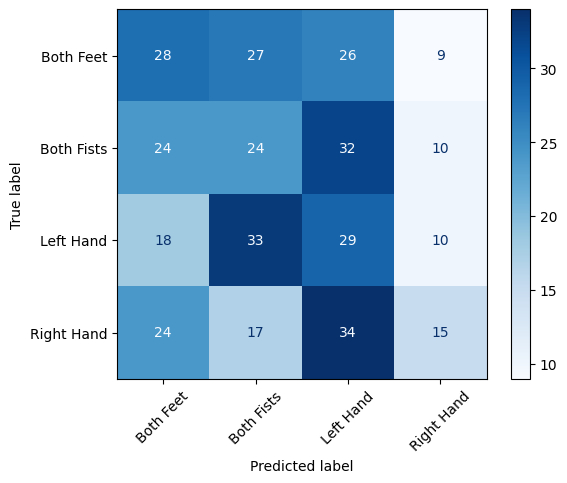

In [ ]:
# Confusion matrix (already computed above, but display it)
cm = confusion_matrix(y_true_all, y_pred_all)
disp = ConfusionMatrixDisplay(cm, display_labels=unique_labels)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, values_format='d')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.show()

# Print confusion matrix as percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
print("\nConfusion Matrix (Percentages):")
for i, label in enumerate(unique_labels):
    print(f"{label:15s}: ", end="")
    for j in range(len(unique_labels)):
        print(f"{cm_percent[i,j]:6.1f}%", end="  ")
    print()


In [ ]:
# Save final model and normalization statistics
torch.save(model.state_dict(), "/content/drive/MyDrive/eegnet_5class.pth")

# Save normalization statistics (mean and std per channel)
np.save("/content/drive/MyDrive/train_mean.npy", train_mean.squeeze())
np.save("/content/drive/MyDrive/train_std.npy", train_std.squeeze())

# Save label mapping
import json
label_map_save = {str(k): int(v) for k, v in label_map.items()}
with open("/content/drive/MyDrive/label_map.json", "w") as f:
    json.dump(label_map_save, f)

print("Model and preprocessing statistics saved!")
print(f"Label mapping: {label_map}")


Using device: cpu
Model loaded successfully!
Processing run 1: /content/drive/MyDrive/files 2/S052/S052R01.edf
Processing run 2: /content/drive/MyDrive/files 2/S052/S052R02.edf
Processing run 3: /content/drive/MyDrive/files 2/S052/S052R03.edf
Processing run 4: /content/drive/MyDrive/files 2/S052/S052R04.edf
Processing run 5: /content/drive/MyDrive/files 2/S052/S052R05.edf
Processing run 6: /content/drive/MyDrive/files 2/S052/S052R06.edf
Processing run 7: /content/drive/MyDrive/files 2/S052/S052R07.edf
Processing run 8: /content/drive/MyDrive/files 2/S052/S052R08.edf
Processing run 9: /content/drive/MyDrive/files 2/S052/S052R09.edf
Processing run 10: /content/drive/MyDrive/files 2/S052/S052R10.edf
Processing run 11: /content/drive/MyDrive/files 2/S052/S052R11.edf
Processing run 12: /content/drive/MyDrive/files 2/S052/S052R12.edf
Processing run 13: /content/drive/MyDrive/files 2/S052/S052R13.edf
Processing run 14: /content/drive/MyDrive/files 2/S052/S052R14.edf


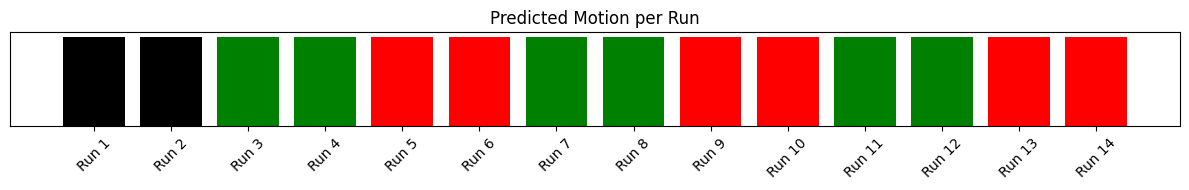

Predicted motions per run: ['Unknown', 'Unknown', 'Right Hand', 'Right Hand', 'Both Feet', 'Both Feet', 'Right Hand', 'Right Hand', 'Both Feet', 'Both Feet', 'Right Hand', 'Right Hand', 'Both Feet', 'Both Feet']


In [ ]:
import os
import mne
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import Counter

# =========================
# 1️⃣ Device setup
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# =========================
# 2️⃣ Paths & parameters
# =========================
subject_folder = "/content/drive/MyDrive/files 2/S052"  # change per subject
model_path = "/content/drive/MyDrive/eegnet_5class.pth"
mean_path = "/content/drive/MyDrive/train_mean.npy"
std_path = "/content/drive/MyDrive/train_std.npy"
label_map_path = "/content/drive/MyDrive/label_map.json"

freq_low, freq_high = 8., 30.     # motor imagery band
target_sfreq = 256                # Must match training
tmin, tmax = 0, 4                 # epoch window
target_samples = int(target_sfreq * (tmax - tmin))  # 256 * 4 = 1024

# =========================
# 3️⃣ Load training mean/std and label mapping
# =========================
train_mean = np.load(mean_path)  # Shape: (n_channels,)
train_std = np.load(std_path)    # Shape: (n_channels,)

# Reshape for broadcasting: (1, n_channels, 1)
train_mean = train_mean.reshape(1, -1, 1)
train_std = train_std.reshape(1, -1, 1)

with open(label_map_path, "r") as f:
    label_map_str = json.load(f)
    # Reverse mapping: int -> label
    label_map = {int(v): k for k, v in label_map_str.items()}

print(f"Loaded normalization stats: mean shape {train_mean.shape}, std shape {train_std.shape}")
print(f"Label mapping: {label_map}")

# =========================
# 4️⃣ EEGNet definition (same as training)
# =========================
import torch.nn as nn

class EEGNet(nn.Module):
    def __init__(self, n_classes, Chans=64, Samples=1024, dropout_rate=0.5):
        super(EEGNet, self).__init__()
        self.n_classes = n_classes
        
        # Block 1: Temporal Convolution (learn temporal features)
        self.conv1 = nn.Conv2d(1, 16, (1, 64), padding=0, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(16, momentum=0.01, affine=True, eps=1e-3)
        
        # Block 2: Depthwise Convolution
        self.conv2 = nn.Conv2d(16, 32, (Chans, 1), groups=16, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(32, momentum=0.01, affine=True, eps=1e-3)
        self.elu1 = nn.ELU()
        self.avgpool1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Block 3: Separable Convolution
        self.conv3_sep = nn.Conv2d(32, 32, (1, 16), padding=(0, 8), groups=32, bias=False)
        self.conv3_point = nn.Conv2d(32, 32, (1, 1), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(32, momentum=0.01, affine=True, eps=1e-3)
        self.elu2 = nn.ELU()
        self.avgpool2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Classifier
        self.classifier = None
        
    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.batchnorm1(x)
        
        # Block 2
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.elu1(x)
        x = self.avgpool1(x)
        x = self.dropout1(x)
        
        # Block 3
        x = self.conv3_sep(x)
        x = self.conv3_point(x)
        x = self.batchnorm3(x)
        x = self.elu2(x)
        x = self.avgpool2(x)
        x = self.dropout2(x)
        
        # Flatten and classify
        x = x.view(x.size(0), -1)
        
        if self.classifier is None:
            self.classifier = nn.Linear(x.shape[1], self.n_classes).to(x.device)
        
        x = self.classifier(x)
        return x

# =========================
# 5️⃣ Map annotations to motions (for reference)
# =========================
def map_annotation_to_motion(code, run):
    """
    Maps annotation codes to motion labels based on run number.
    Note: This is for reference. We'll use model predictions instead.
    """
    if code == 0:
        return "Rest"
    if run in [3,4,7,8,11,12]:
        return "Left Hand" if code == 1 else "Right Hand"
    if run in [5,6,9,10,13,14]:
        return "Both Fists" if code == 1 else "Both Feet"
    return "Unknown"

# =========================
# 6️⃣ Load trained model
# =========================
# Estimate channels and create model
sample_file = os.path.join(subject_folder, os.listdir(subject_folder)[0])
sample_raw = mne.io.read_raw_edf(sample_file, preload=True, verbose=False)
n_channels = sample_raw.info["nchan"]
n_classes = len(label_map)

print(f"Model parameters: n_classes={n_classes}, n_channels={n_channels}, n_samples={target_samples}")

model = EEGNet(n_classes=n_classes, Chans=n_channels, Samples=target_samples, dropout_rate=0.5).to(device)

# Load a dummy input to initialize the classifier
dummy_input = torch.zeros(1, 1, n_channels, target_samples).to(device)
_ = model(dummy_input)

# Load trained weights
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict, strict=True)
model.eval()
print("Model loaded successfully!")

# =========================
# 7️⃣ Process all EDF files
# =========================
edf_files = sorted([os.path.join(subject_folder, f) for f in os.listdir(subject_folder) if f.endswith(".edf")])
predicted_runs = []
all_run_predictions = []

for run_idx, file in enumerate(edf_files):
    run_num = run_idx + 1  # 1-based run number
    print(f"Processing run {run_num}: {os.path.basename(file)}")
    
    raw = mne.io.read_raw_edf(file, preload=True, verbose=False)
    raw.filter(freq_low, freq_high, verbose=False, fir_design='firwin')
    
    if raw.info["sfreq"] != target_sfreq:
        raw.resample(target_sfreq, npad="auto")

    events, event_id = mne.events_from_annotations(raw, verbose=False)
    if len(event_id) == 0:
        print("  No annotations, defaulting to Rest")
        predicted_runs.append("Rest")
        continue

    epochs = mne.Epochs(raw, events, event_id=event_id,
                        tmin=tmin, tmax=tmax,
                        baseline=(-0.5, 0),  # Baseline correction
                        preload=True, verbose=False)
    
    if len(epochs) == 0:
        predicted_runs.append("Rest")
        continue

    X = epochs.get_data()  # (n_epochs, n_channels, n_samples)
    
    # Normalize using training statistics
    X_norm = (X - train_mean) / (train_std + 1e-8)
    X_tensor = torch.tensor(X_norm, dtype=torch.float32).unsqueeze(1).to(device)

    # Predict per epoch
    with torch.no_grad():
        out = model(X_tensor)
        probs = torch.softmax(out, dim=1)
        preds = out.argmax(dim=1).cpu().numpy()
        confidences = probs.max(dim=1)[0].cpu().numpy()
    
    # Map predictions to labels
    epoch_labels = [label_map[p] for p in preds]
    
    # Majority vote for run-level prediction
    label_counts = Counter(epoch_labels)
    run_motion = label_counts.most_common(1)[0][0]
    predicted_runs.append(run_motion)
    
    all_run_predictions.append({
        'run': run_num,
        'epoch_labels': epoch_labels,
        'confidences': confidences.tolist(),
        'run_prediction': run_motion
    })
    
    print(f"  Predicted: {run_motion} (avg confidence: {confidences.mean():.3f})")

# =========================
# 8️⃣ Plot predictions against runs
# =========================
plt.figure(figsize=(14, 4))
colors = {"Rest": "gray", "Left Hand": "blue", "Right Hand": "green", 
          "Both Fists": "orange", "Both Feet": "red", "Unknown": "black"}

for idx, motion in enumerate(predicted_runs):
    plt.bar(idx, 1, color=colors.get(motion, "black"), label=motion if idx == 0 else "")

plt.xticks(range(len(predicted_runs)), [f"Run {i+1}" for i in range(len(predicted_runs))], rotation=45)
plt.yticks([])
plt.title("Predicted Motion per Run - Subject S052")
plt.xlabel("Run")
plt.ylabel("Motion Class")
plt.tight_layout()
plt.show()

print("\nPredicted motions per run:")
for i, motion in enumerate(predicted_runs):
    print(f"  Run {i+1:2d}: {motion}")


Using device: cpu
Model loaded successfully!
Processing run 1: /content/drive/MyDrive/files 2/S027/S027R01.edf
Processing run 2: /content/drive/MyDrive/files 2/S027/S027R02.edf
Processing run 3: /content/drive/MyDrive/files 2/S027/S027R03.edf
Processing run 4: /content/drive/MyDrive/files 2/S027/S027R04.edf
Processing run 5: /content/drive/MyDrive/files 2/S027/S027R05.edf
Processing run 6: /content/drive/MyDrive/files 2/S027/S027R06.edf
Processing run 7: /content/drive/MyDrive/files 2/S027/S027R07.edf
Processing run 8: /content/drive/MyDrive/files 2/S027/S027R08.edf
Processing run 9: /content/drive/MyDrive/files 2/S027/S027R09.edf
Processing run 10: /content/drive/MyDrive/files 2/S027/S027R10.edf
Processing run 11: /content/drive/MyDrive/files 2/S027/S027R11.edf
Processing run 12: /content/drive/MyDrive/files 2/S027/S027R12.edf
Processing run 13: /content/drive/MyDrive/files 2/S027/S027R13.edf
Processing run 14: /content/drive/MyDrive/files 2/S027/S027R14.edf


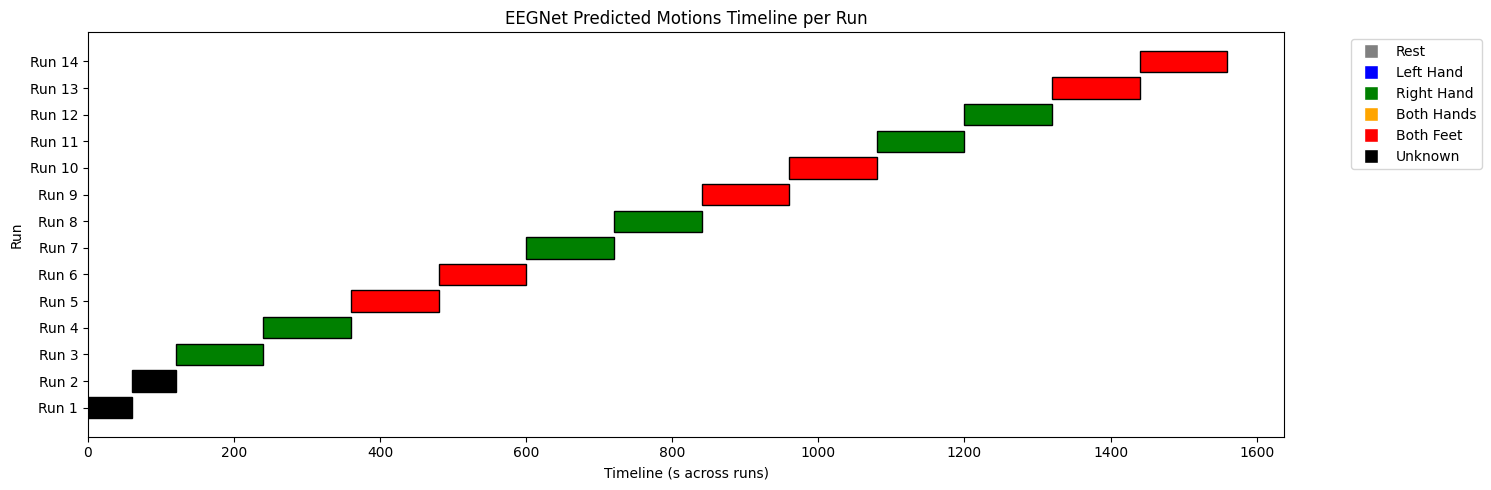

Predicted motions per run: ['Unknown', 'Unknown', 'Right Hand', 'Right Hand', 'Both Feet', 'Both Feet', 'Right Hand', 'Right Hand', 'Both Feet', 'Both Feet', 'Right Hand', 'Right Hand', 'Both Feet', 'Both Feet']


In [ ]:
import os
import mne
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import Counter

# =========================
# 1️⃣ Device setup
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# =========================
# 2️⃣ Paths & parameters
# =========================
subject_folder = "/content/drive/MyDrive/files 2/S027"  # change per subject
model_path = "/content/drive/MyDrive/eegnet_5class.pth"
mean_path = "/content/drive/MyDrive/train_mean.npy"
std_path = "/content/drive/MyDrive/train_std.npy"
label_map_path = "/content/drive/MyDrive/label_map.json"

freq_low, freq_high = 8., 30.     # motor imagery band
target_sfreq = 256                # Must match training
tmin, tmax = 0, 4                 # epoch window
target_samples = int(target_sfreq * (tmax - tmin))  # 256 * 4 = 1024

# Run durations in seconds (baseline 60s, tasks 120s)
run_durations = [60, 60, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120]

# =========================
# 3️⃣ Load training mean/std and label mapping
# =========================
train_mean = np.load(mean_path)  # Shape: (n_channels,)
train_std = np.load(std_path)    # Shape: (n_channels,)

# Reshape for broadcasting: (1, n_channels, 1)
train_mean = train_mean.reshape(1, -1, 1)
train_std = train_std.reshape(1, -1, 1)

with open(label_map_path, "r") as f:
    label_map_str = json.load(f)
    # Reverse mapping: int -> label
    label_map = {int(v): k for k, v in label_map_str.items()}

print(f"Loaded normalization stats: mean shape {train_mean.shape}, std shape {train_std.shape}")
print(f"Label mapping: {label_map}")

# =========================
# 4️⃣ EEGNet definition (same as training)
# =========================
import torch.nn as nn

class EEGNet(nn.Module):
    def __init__(self, n_classes, Chans=64, Samples=1024, dropout_rate=0.5):
        super(EEGNet, self).__init__()
        self.n_classes = n_classes
        
        # Block 1: Temporal Convolution (learn temporal features)
        self.conv1 = nn.Conv2d(1, 16, (1, 64), padding=0, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(16, momentum=0.01, affine=True, eps=1e-3)
        
        # Block 2: Depthwise Convolution
        self.conv2 = nn.Conv2d(16, 32, (Chans, 1), groups=16, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(32, momentum=0.01, affine=True, eps=1e-3)
        self.elu1 = nn.ELU()
        self.avgpool1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Block 3: Separable Convolution
        self.conv3_sep = nn.Conv2d(32, 32, (1, 16), padding=(0, 8), groups=32, bias=False)
        self.conv3_point = nn.Conv2d(32, 32, (1, 1), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(32, momentum=0.01, affine=True, eps=1e-3)
        self.elu2 = nn.ELU()
        self.avgpool2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Classifier
        self.classifier = None
        
    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.batchnorm1(x)
        
        # Block 2
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.elu1(x)
        x = self.avgpool1(x)
        x = self.dropout1(x)
        
        # Block 3
        x = self.conv3_sep(x)
        x = self.conv3_point(x)
        x = self.batchnorm3(x)
        x = self.elu2(x)
        x = self.avgpool2(x)
        x = self.dropout2(x)
        
        # Flatten and classify
        x = x.view(x.size(0), -1)
        
        if self.classifier is None:
            self.classifier = nn.Linear(x.shape[1], self.n_classes).to(x.device)
        
        x = self.classifier(x)
        return x

# =========================
# 5️⃣ Load trained model
# =========================
# Estimate channels and create model
sample_file = os.path.join(subject_folder, os.listdir(subject_folder)[0])
sample_raw = mne.io.read_raw_edf(sample_file, preload=True, verbose=False)
n_channels = sample_raw.info["nchan"]
n_classes = len(label_map)

print(f"Model parameters: n_classes={n_classes}, n_channels={n_channels}, n_samples={target_samples}")

model = EEGNet(n_classes=n_classes, Chans=n_channels, Samples=target_samples, dropout_rate=0.5).to(device)

# Load a dummy input to initialize the classifier
dummy_input = torch.zeros(1, 1, n_channels, target_samples).to(device)
_ = model(dummy_input)

# Load trained weights
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict, strict=True)
model.eval()
print("Model loaded successfully!")

# =========================
# 6️⃣ Process all EDF files
# =========================
edf_files = sorted([os.path.join(subject_folder, f) for f in os.listdir(subject_folder) if f.endswith(".edf")])
predicted_runs = []

for run_idx, file in enumerate(edf_files):
    run_num = run_idx + 1  # 1-based run number
    print(f"Processing run {run_num}: {os.path.basename(file)}")
    
    raw = mne.io.read_raw_edf(file, preload=True, verbose=False)
    raw.filter(freq_low, freq_high, verbose=False, fir_design='firwin')
    
    if raw.info["sfreq"] != target_sfreq:
        raw.resample(target_sfreq, npad="auto")

    events, event_id = mne.events_from_annotations(raw, verbose=False)
    if len(event_id) == 0:
        print("  No annotations, defaulting to Rest")
        predicted_runs.append("Rest")
        continue

    epochs = mne.Epochs(raw, events, event_id=event_id,
                        tmin=tmin, tmax=tmax,
                        baseline=(-0.5, 0),  # Baseline correction
                        preload=True, verbose=False)
    
    if len(epochs) == 0:
        predicted_runs.append("Rest")
        continue

    X = epochs.get_data()  # (n_epochs, n_channels, n_samples)
    
    # Normalize using training statistics
    X_norm = (X - train_mean) / (train_std + 1e-8)
    X_tensor = torch.tensor(X_norm, dtype=torch.float32).unsqueeze(1).to(device)

    # Predict per epoch
    with torch.no_grad():
        out = model(X_tensor)
        preds = out.argmax(dim=1).cpu().numpy()
    
    # Map predictions to labels
    epoch_labels = [label_map[p] for p in preds]
    
    # Majority vote for run-level prediction
    label_counts = Counter(epoch_labels)
    run_motion = label_counts.most_common(1)[0][0]
    predicted_runs.append(run_motion)
    
    print(f"  Predicted: {run_motion}")

# =========================
# 7️⃣ Plot timeline vs runs
# =========================
colors = {"Rest": "gray", "Left Hand": "blue", "Right Hand": "green", 
          "Both Fists": "orange", "Both Feet": "red", "Unknown": "black"}

plt.figure(figsize=(15, 6))
timeline_start = 0
for run_idx, motion in enumerate(predicted_runs):
    duration = run_durations[run_idx]
    plt.barh(run_idx+1, width=duration, left=timeline_start, 
             color=colors.get(motion, "black"), edgecolor='black', linewidth=1.5)
    timeline_start += duration

plt.xlabel("Timeline (seconds across runs)", fontsize=12)
plt.ylabel("Run", fontsize=12)
plt.yticks(range(1, len(predicted_runs)+1), [f"Run {i+1}" for i in range(len(predicted_runs))])
plt.title("EEGNet Predicted Motions Timeline per Run - Subject S027", fontsize=14)

# Legend
handles = [plt.Rectangle((0,0),1,1, facecolor=c, edgecolor='black') for c in colors.values()]
plt.legend(handles, colors.keys(), loc='upper left', bbox_to_anchor=(1.02, 1))
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nPredicted motions per run:")
for i, motion in enumerate(predicted_runs):
    print(f"  Run {i+1:2d}: {motion} (duration: {run_durations[i]}s)")
